# Research Paper Clustering

## Objective
Cluster a given set of research papers based on their abstract similarity using natural language processing, text preprocessing, and unsupervised machine learning.

# 1. Setup and Dependencies

In [38]:
import os
import re 
import string
import pandas as pd
from PyPDF2 import PdfReader
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/savannahfung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/savannahfung/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Data Preprocessing

In [39]:
# Directory containing PDF files
pdf_dir = "Green Energy Dataset"

In [40]:
# Function to extract text from PDF files
def extract_text(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PdfReader(file)
        text = ""
        for page_num in range(min(2, len(reader.pages))):
            text += reader.pages[page_num].extract_text()
    return text

# Function to extract abstract content from text
def extract_abstract(text, min_words=90, max_words=300):
    abstract = ""
    pattern = re.compile(r'(^|\n)\s*(abstract|summary)\s*([\s\S]*?)(introduction|keywords)', re.IGNORECASE)
    match = pattern.search(text)
    if match:
        abstract = match.group(3).strip()
        remaining_text = text[match.end():]
    else:
        paragraphs = re.split(r'\n\s*\n', text)
        if len(paragraphs) > 0:
            abstract = paragraphs[0].strip()
            remaining_text = '\n\n'.join(paragraphs[1:])

    words = abstract.split()
    if len(words) < min_words:
        paragraphs = re.split(r'\n\s*\n', remaining_text)
        for paragraph in paragraphs:
            abstract += " " + paragraph.strip()
            words = abstract.split()
            if len(words) >= min_words:
                break
    elif len(words) > max_words:
        abstract = ' '.join(words[:max_words])

    return abstract

# Function to preprocess text
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text) 
    # Remove email addresses
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b', '', text) 
    # Normalize unicode characters
    text = unicodedata.normalize('NFKD', text)
    # Lowercase the text
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation and special characters
    text = ''.join(ch for ch in text if not unicodedata.category(ch).startswith('P')) 
    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join words back into a single string
    return ' '.join(words)

In [41]:
# Initialize a list to store processed abstracts
abstracts = []

# Iterate through all PDF files in the directory
for pdf_file in os.listdir(pdf_dir):
    if pdf_file.endswith('.pdf'):
        pdf_path = os.path.join(pdf_dir, pdf_file)
        raw_text = extract_text(pdf_path)
        raw_abstract = extract_abstract(raw_text)
        processed_abstract = preprocess_text(raw_abstract)
        abstracts.append({
            'filename': pdf_file,
            'raw_text': raw_text,
            'raw_abstract': raw_abstract,
            'processed_abstract': processed_abstract
        })

In [42]:
# Convert the list of dictionaries to a pandas DataFrame
abstracts_df = pd.DataFrame(abstracts)

# Visualize the DataFrame
print(abstracts_df.head())

                                            filename  \
0  Model_Predictive_Current_Control_of_Nine-Phase...   
1                                science.ade1499.pdf   
2  huang-et-al-2022-bacterial-growth-induced-tobr...   
3  Voltage_Sensorless_Based_Model_Predictive_Cont...   
4                     sustainability-15-01418-v2.pdf   

                                            raw_text  \
0  IEEE TRANSACTIONS ON INDUSTRIAL ELECTRONICS, V...   
1  ELECTROCHEMISTRY\nLa- and Mn-doped cobalt spin...   
2  Bacterial Growth-Induced Tobramycin Smart\nRel...   
3  IEEE TRANSACTIONS ON TRANSPORTATION ELEC TRIFI...   
4  Citation: Obaideen, K.; Olabi, A.G.;\nAl Swail...   

                                        raw_abstract  \
0  —The current error is hard to avoid for ﬁnite\...   
1  ELECTROCHEMISTRY La- and Mn-doped cobalt spine...   
2  :\n Burnsareacommonhealthproblemworldwideandar...   
3  IEEE TRANSACTIONS ON TRANSPORTATION ELEC TRIFI...   
4  : Over the past decade, energy demand has w

In [43]:
# Check for null values
print("Null values in DataFrame:")
print(abstracts_df.isnull().sum())
print()

# Summary statistics
abstracts_df['abstract_length'] = abstracts_df['processed_abstract'].apply(lambda x: len(x.split()))
print("Summary statistics:")
print(abstracts_df['abstract_length'].describe())

Null values in DataFrame:
filename              0
raw_text              0
raw_abstract          0
processed_abstract    0
dtype: int64

Summary statistics:
count     79.000000
mean     195.594937
std       49.483102
min       92.000000
25%      188.500000
50%      203.000000
75%      213.000000
max      504.000000
Name: abstract_length, dtype: float64


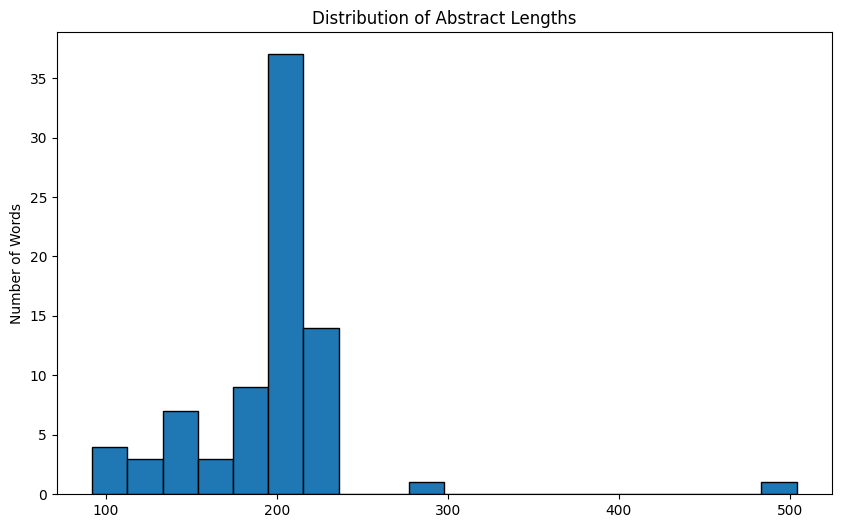

In [44]:
# Plot histogram of abstract lengths
plt.figure(figsize=(10, 6))
plt.hist(abstracts_df['abstract_length'], bins=20, edgecolor='black')
plt.title('Distribution of Abstract Lengths')
plt.ylabel('Number of Words')
plt.show()


# 3. Text Vectorization

In [45]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=500)

# Fit and transform the abstracts
tfidf_matrix = vectorizer.fit_transform(abstracts_df['processed_abstract'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Visualize the TF-IDF DataFrame
print(tfidf_df.head())

   able  abstract  accepted  access  accurate  achieve  active  activity  \
0   0.0  0.000000  0.000000     0.0       0.0      0.0     0.0       0.0   
1   0.0  0.000000  0.000000     0.0       0.0      0.0     0.0       0.0   
2   0.0  0.000000  0.146088     0.0       0.0      0.0     0.0       0.0   
3   0.0  0.048963  0.000000     0.0       0.0      0.0     0.0       0.0   
4   0.0  0.000000  0.000000     0.0       0.0      0.0     0.0       0.0   

   addition  additionally  ...      wind    within   without      work  \
0       0.0           0.0  ...  0.000000  0.000000  0.166687  0.000000   
1       0.0           0.0  ...  0.052408  0.000000  0.000000  0.000000   
2       0.0           0.0  ...  0.000000  0.000000  0.000000  0.000000   
3       0.0           0.0  ...  0.000000  0.000000  0.000000  0.076074   
4       0.0           0.0  ...  0.000000  0.065271  0.000000  0.000000   

      world  worldwide      year      zero  zhang  zhejiang  
0  0.000000   0.000000  0.000000  0.

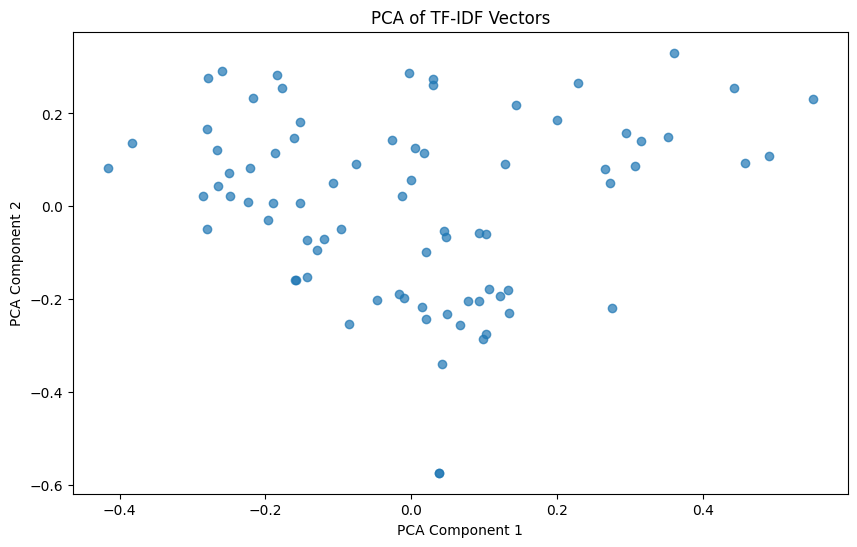

In [46]:
# Perform PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(pca_result, columns=['pca1', 'pca2'])

# Visualize the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['pca1'], pca_df['pca2'], alpha=0.7)
plt.title('PCA of TF-IDF Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# 4. Clustering

In [47]:
# Apply LDA for topic modeling
n_topics = 3
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_matrix = lda_model.fit_transform(tfidf_matrix)

# Standardize the LDA matrix
scaler = StandardScaler()
lda_matrix_scaled = scaler.fit_transform(lda_matrix)

/Users/savannahfung/Documents/outread assessment/research-paper-clustering/venv/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (78) found smaller than n_clusters (79). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


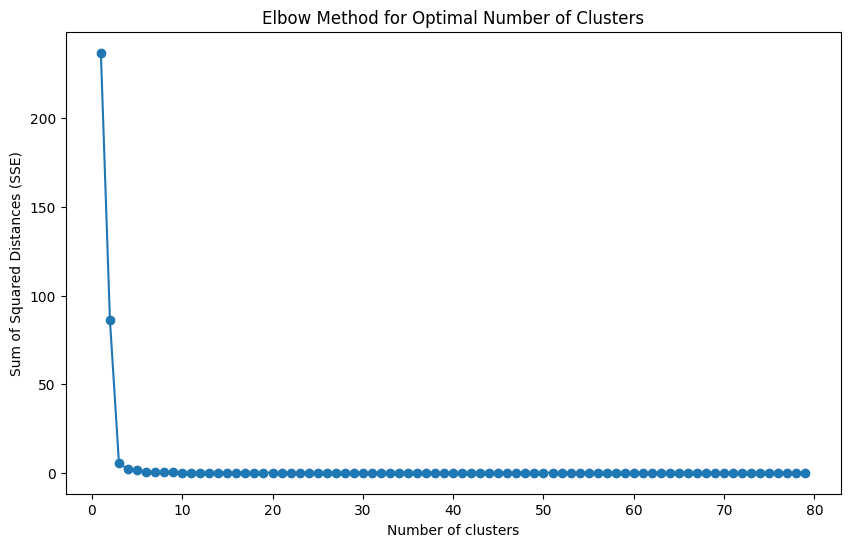

In [48]:
# Determine optimal number of clusters using the elbow method
sse = [] 
i_values = range(1, 80)
for i in i_values:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(lda_matrix_scaled)
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(i_values, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

/Users/savannahfung/Documents/outread assessment/research-paper-clustering/venv/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (78) found smaller than n_clusters (79). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


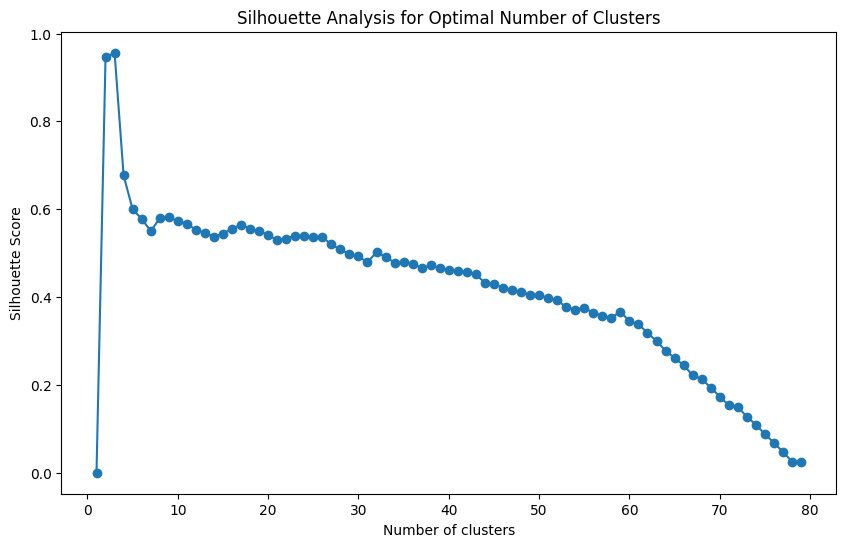

In [49]:
# Determine optimal number of clusters using the silhouette analysis
silhouette_scores = []
for i in i_values:
    kmeans = KMeans(n_clusters=i, random_state=42)
    labels = kmeans.fit_predict(lda_matrix_scaled)
    if len(set(labels)) == 1:
        silhouette_scores.append(0)
    else:
        silhouette_scores.append(silhouette_score(lda_matrix_scaled, labels))

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(i_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal Number of Clusters')
plt.show()

In [50]:
# Fit KMeans with optimal number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(lda_matrix_scaled)
print("Cluster Labels:", labels)

Cluster Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0]


In [51]:
# Evaluate the clustering using silhouette score, Davies-Bouldin index, and Calinski-Harabasz index
silhouette_avg = silhouette_score(lda_matrix_scaled, labels)
davies_bouldin_avg = davies_bouldin_score(lda_matrix_scaled, labels)
calinski_harabasz_avg = calinski_harabasz_score(lda_matrix_scaled, labels)

# Display the evaluation metrics
print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Index: {davies_bouldin_avg}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_avg}')

Silhouette Score: 0.9562368009726722
Davies-Bouldin Index: 0.021645594778547033
Calinski-Harabasz Index: 1608.9750661549806


# 5. Visualization

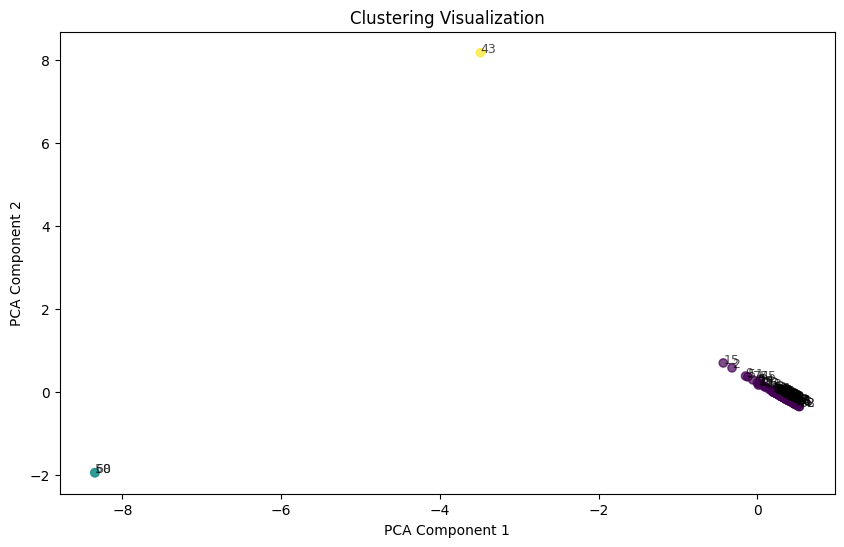

In [52]:
# Visualize the clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(lda_matrix_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)

# Annotate each point with the corresponding research paper index
for i in range(len(abstracts_df)):
    plt.text(X_pca[i, 0], X_pca[i, 1], i, fontsize=9, alpha=0.7)
    
plt.title('Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# 6. Output Generation

In [53]:
# Create a DataFrame to store the results
results = pd.DataFrame({'Research Paper': abstracts_df['filename'], 'Cluster': labels})
# Display results
print(results)

                                       Research Paper  Cluster
0   Model_Predictive_Current_Control_of_Nine-Phase...        0
1                                 science.ade1499.pdf        0
2   huang-et-al-2022-bacterial-growth-induced-tobr...        0
3   Voltage_Sensorless_Based_Model_Predictive_Cont...        0
4                      sustainability-15-01418-v2.pdf        0
..                                                ...      ...
74  IET Smart Grid - 2024 - AhmadiAhangar - Impact...        0
75  wang-et-al-2023-the-impact-of-economic-corrido...        0
76                          s41560-020-0550-8 (2).pdf        0
77                  1-s2.0-S0360319922007066-main.pdf        0
78                  1-s2.0-S0306261919309213-main.pdf        0

[79 rows x 2 columns]


In [54]:
# Save the results to a CSV file
results.to_csv('clustering_results.csv', index=False)

In [55]:
# Display a summary of the number of research papers in each cluster
summary = results.groupby('Cluster').count()
summary.columns = ['Number of Research Papers']
print(summary)
print()

# Display the key terms or topics for each cluster
print("Top 10 terms for each cluster:")
cluster_terms = []
for i in range(n_topics):
    cluster_terms.append(tfidf_df.loc[lda_matrix.argmax(axis=1) == i].mean().sort_values(ascending=False).head(10).index.tolist())
    print(f'Cluster {i} Terms:', cluster_terms[i])

         Number of Research Papers
Cluster                           
0                               76
1                                2
2                                1

Top 10 terms for each cluster:
Cluster 0 Terms: ['able', 'abstract', 'accepted', 'access', 'accurate', 'achieve', 'active', 'activity', 'addition', 'additionally']
Cluster 1 Terms: ['energy', 'hydrogen', 'system', 'battery', 'solar', 'green', 'university', 'power', 'technology', 'wind']
Cluster 2 Terms: ['boe', 'pg', 'uif', 'catalyst', 'synthesis', 'sfbdujpot', 'up', 'difnjdbm', 'joufsbdujpo', 'nanomaterials']
